<a href="https://www.kaggle.com/code/mh0386/logistic-regression-with-least-squares-technique?scriptVersionId=244761054" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
from sys import float_info

import numpy as np
from matplotlib import pyplot
from pandas import get_dummies
from sklearn.datasets import load_iris
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
iris = load_iris()

In [3]:
x = iris.data
y = iris.target

In [4]:
y.shape

(150,)

In [5]:
np.unique(y)

array([0, 1, 2])

# Model


In [6]:
class LogisticRegression:
    def __init__(
        self,
        lr=0.1,
        num_iter=1_000_000,
        verbose=False,
        multi_class=False,
        least_squares=False,
    ) -> None:
        self.lr = lr
        self.num_iter = num_iter
        self.verbose = verbose
        self.least_squares = least_squares
        self.multi_class = multi_class
        self.weights = None
        self.bias = None
        self.classes_ = None
        self.m = None
        self.n = None
        self.losses = []
        self.accuracies = []

    def softmax(self, x: np.ndarray) -> np.ndarray:
        e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return e_x / e_x.sum(axis=1, keepdims=True)

    def gradient_descent(self, x: np.ndarray, y: np.ndarray) -> None:
        y_hat = self.predict(x)
        dw = (1 / self.m) * np.dot(x.T, (y_hat - y))
        db = (1 / self.m) * np.sum(y_hat - y)
        self.weights -= self.lr * dw
        self.bias -= self.lr * db

    def predict(self, x: np.ndarray) -> np.ndarray:
        if self.least_squares:
            x = np.c_[np.ones(x.shape[0]), x]
            return np.dot(x, self.weights)
        z = np.dot(x, self.weights) + self.bias
        predication = 1.0 / (1.0 + np.exp(-z))
        return self.softmax(predication) if self.multi_class else predication

    def plot(self) -> None:
        pyplot.plot(self.losses)
        pyplot.plot(self.accuracies)
        pyplot.xlabel("Number of iterations")
        pyplot.ylabel("Loss")
        pyplot.legend(["Loss", "Accuracy"])
        pyplot.show()

    def loss(self, x: np.ndarray, y: np.ndarray) -> float:
        y_hat = self.predict(x)
        self.losses.append(
            -np.mean(
                y * np.log(y_hat + float_info.min)
                + (1 - y) * np.log(1 - y_hat + float_info.min)
            )
        )
        return self.losses[-1]

    def accuracy(self, x: np.ndarray, y: np.ndarray) -> None:
        y_hat = self.predict(x)
        acc = (
            np.mean(y_hat.argmax(axis=1) == y.argmax(axis=1))
            if self.multi_class
            else np.mean(y_hat.round() == y)
        )
        self.accuracies.append(acc)

    def fit(self, x: np.ndarray, y: np.ndarray) -> None:
        if self.least_squares:
            self.least_squares_technique(x, y)
            return
        best_loss = float_info.max
        patience = 10
        self.m, self.n = x.shape
        if self.multi_class:
            self.classes_ = np.unique(y)
            y = get_dummies(y).to_numpy()
            self.weights = (
                np.random.rand(self.n, len(self.classes_))
                if self.weights is None
                else self.weights
            )
            self.bias = (
                np.random.rand(len(self.classes_)) if self.bias is None else self.bias
            )
        else:
            self.weights = (
                np.random.rand(self.n) if self.weights is None else self.weights
            )
            self.bias = np.random.rand() if self.bias is None else self.bias
        for _ in range(self.num_iter):
            self.gradient_descent(x, y)
            self.loss(x, y)
            self.accuracy(x, y)

            if self.losses[-1] < best_loss:
                best_loss = self.losses[-1]
                patience = 10
            else:
                patience -= 1
                if patience == 0:
                    break

            if self.verbose:
                print(f"\tLoss: {self.losses[-1]}")
                print(f"\tAccuracy: {self.accuracies[-1]}")
        print(f"\nFinal Loss: {self.losses[-1]}")
        print(f"Final Accuracy: {self.accuracies[-1]}")

    def eval(self, x: np.ndarray, y: np.ndarray) -> None:
        if self.multi_class:
            y = get_dummies(y).to_numpy()
        self.accuracy(x, y)
        print(f"Accuracy: {self.accuracies[-1]}")

    def least_squares_technique(self, x: np.ndarray, y: np.ndarray) -> None:
        x = np.c_[np.ones(x.shape[0]), x]
        self.weights = np.dot(np.dot(np.linalg.inv(np.dot(x.T, x)), x.T), y)

In [7]:
np.unique(y)

array([0, 1, 2])

In [8]:
y.shape

(150,)

# With Least Squares Technique

# Group samples of class 2 and class 3 together to form new class

In [9]:
Y_train = np.where(y == 2, 1, y)

X_train_class1, X_test_class1, Y_train_class1, Y_test_class1 = train_test_split(
    x[Y_train == 0], Y_train[Y_train == 0], test_size=0.2, random_state=42
)
X_train_class2, X_test_class2, Y_train_class2, Y_test_class2 = train_test_split(
    x[Y_train == 1], Y_train[Y_train == 1], test_size=0.2, random_state=42
)

X_train = np.concatenate((X_train_class1, X_train_class2), axis=0)
X_test = np.concatenate((X_test_class1, X_test_class2), axis=0)
Y_train = np.concatenate((Y_train_class1, Y_train_class2), axis=0)
Y_test = np.concatenate((Y_test_class1, Y_test_class2), axis=0)

In [10]:
np.unique(
    Y_train
), X_train_class1.shape, X_test_class1.shape, X_train_class2.shape, X_test_class2.shape

(array([0, 1]), (40, 4), (10, 4), (80, 4), (20, 4))

In [11]:
model = LogisticRegression(least_squares=True)

In [12]:
model.fit(X_train, Y_train)

In [13]:
model.eval(X_test, Y_test)

Accuracy: 1.0


In [14]:
Y_pred = model.predict(X_test)

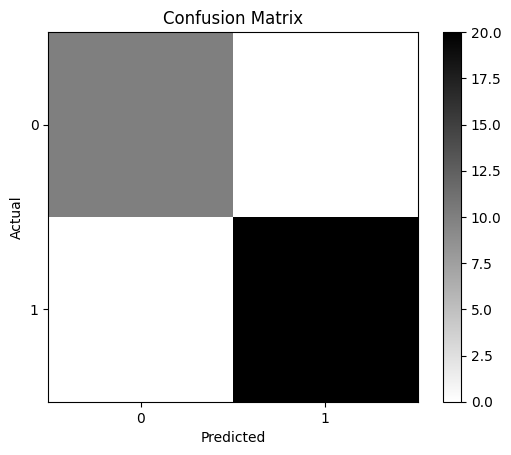

In [15]:
confusion_matrix(Y_test, Y_pred.round())
pyplot.imshow(
    confusion_matrix(Y_test, Y_pred.round()), cmap="binary", interpolation="None"
)
pyplot.title("Confusion Matrix")
pyplot.xlabel("Predicted")
pyplot.ylabel("Actual")
pyplot.xticks([0, 1])
pyplot.yticks([0, 1])
pyplot.colorbar()
pyplot.show()

# Group samples of class 1 and class 3 together to form new class

In [16]:
Y_train = np.where(y == 2, 0, y)

X_train_class1, X_test_class1, Y_train_class1, Y_test_class1 = train_test_split(
    x[Y_train == 0], Y_train[Y_train == 0], test_size=0.2, random_state=42
)
X_train_class2, X_test_class2, Y_train_class2, Y_test_class2 = train_test_split(
    x[Y_train == 1], Y_train[Y_train == 1], test_size=0.2, random_state=42
)

X_train = np.concatenate((X_train_class1, X_train_class2), axis=0)
X_test = np.concatenate((X_test_class1, X_test_class2), axis=0)
Y_train = np.concatenate((Y_train_class1, Y_train_class2), axis=0)
Y_test = np.concatenate((Y_test_class1, Y_test_class2), axis=0)

In [17]:
np.unique(
    Y_train
), X_train_class1.shape, X_test_class1.shape, X_train_class2.shape, X_test_class2.shape

(array([0, 1]), (80, 4), (20, 4), (40, 4), (10, 4))

In [18]:
model = LogisticRegression(least_squares=True)

In [19]:
model.fit(X_train, Y_train)

In [20]:
model.eval(X_test, Y_test)

Accuracy: 0.8


In [21]:
Y_pred = model.predict(X_test)

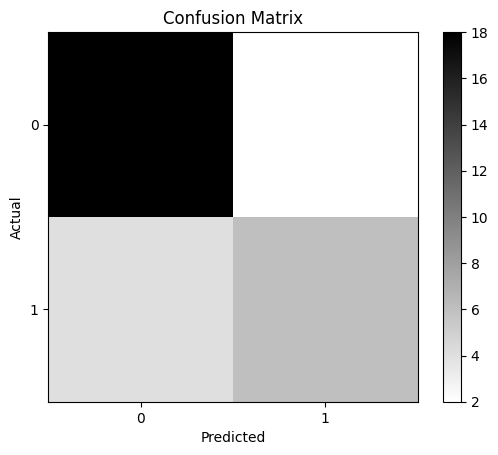

In [22]:
confusion_matrix(Y_test, Y_pred.round())
pyplot.imshow(
    confusion_matrix(Y_test, Y_pred.round()), cmap="binary", interpolation="None"
)
pyplot.title("Confusion Matrix")
pyplot.xlabel("Predicted")
pyplot.ylabel("Actual")
pyplot.xticks([0, 1])
pyplot.yticks([0, 1])
pyplot.colorbar()
pyplot.show()

# Group samples of class 1 and class 2 together to form new class

In [23]:
Y_train = np.where(y == 1, 0, y)
Y_train = np.where(y == 2, 1, Y_train)

X_train_class1, X_test_class1, Y_train_class1, Y_test_class1 = train_test_split(
    x[Y_train == 0], Y_train[Y_train == 0], test_size=0.2, random_state=42
)
X_train_class2, X_test_class2, Y_train_class2, Y_test_class2 = train_test_split(
    x[Y_train == 1], Y_train[Y_train == 1], test_size=0.2, random_state=42
)

X_train = np.concatenate((X_train_class1, X_train_class2), axis=0)
X_test = np.concatenate((X_test_class1, X_test_class2), axis=0)
Y_train = np.concatenate((Y_train_class1, Y_train_class2), axis=0)
Y_test = np.concatenate((Y_test_class1, Y_test_class2), axis=0)

In [24]:
np.unique(
    Y_train
), X_train_class1.shape, X_test_class1.shape, X_train_class2.shape, X_test_class2.shape

(array([0, 1]), (80, 4), (20, 4), (40, 4), (10, 4))

In [25]:
model = LogisticRegression(least_squares=True)

In [26]:
model.fit(X_train, Y_train)

In [27]:
model.eval(X_test, Y_test)

Accuracy: 0.9


In [28]:
Y_pred = model.predict(X_test)

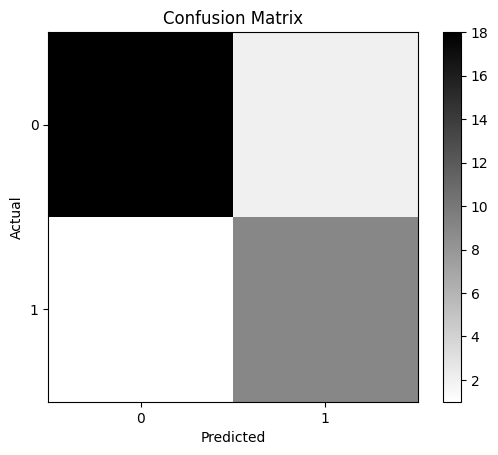

In [29]:
confusion_matrix(Y_test, Y_pred.round())
pyplot.imshow(confusion_matrix(Y_test, Y_pred.round()), cmap="binary")
pyplot.title("Confusion Matrix")
pyplot.xlabel("Predicted")
pyplot.ylabel("Actual")
pyplot.xticks([0, 1])
pyplot.yticks([0, 1])
pyplot.colorbar()
pyplot.show()

# With Gradient Descent

In [30]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=42
)

In [31]:
model = LogisticRegression(multi_class=True)

In [32]:
x_train = (x_train - x_train.mean()) / x_train.std()
x_test = (x_test - x_test.mean()) / x_test.std()

In [33]:
model.fit(x_train, y_train)

/tmp/ipykernel_13/1924661098.py:39: RuntimeWarning: overflow encountered in exp
  predication = 1.0 / (1.0 + np.exp(-z))



Final Loss: 0.4708915991892737
Final Accuracy: 0.6761904761904762


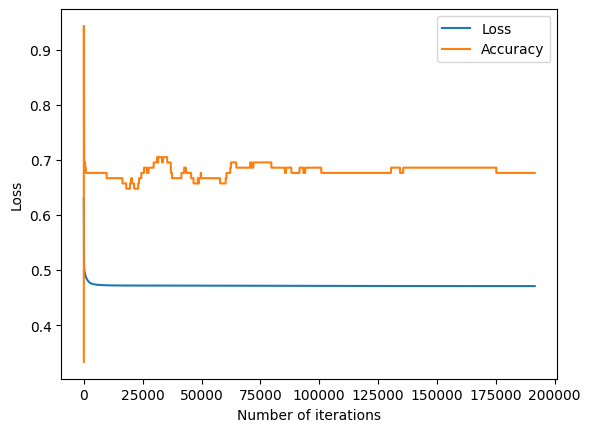

In [34]:
model.plot()

In [35]:
model.eval(x_test, y_test)

Accuracy: 0.7111111111111111


/tmp/ipykernel_13/1924661098.py:39: RuntimeWarning: overflow encountered in exp
  predication = 1.0 / (1.0 + np.exp(-z))


# Group samples of class 2 and class 3 together to form new class

In [36]:
Y_train = np.where(y == 2, 1, y)

X_train_class1, X_test_class1, Y_train_class1, Y_test_class1 = train_test_split(
    x[Y_train == 0], Y_train[Y_train == 0], test_size=0.2, random_state=42
)
X_train_class2, X_test_class2, Y_train_class2, Y_test_class2 = train_test_split(
    x[Y_train == 1], Y_train[Y_train == 1], test_size=0.2, random_state=42
)

X_train = np.concatenate((X_train_class1, X_train_class2), axis=0)
X_test = np.concatenate((X_test_class1, X_test_class2), axis=0)
Y_train = np.concatenate((Y_train_class1, Y_train_class2), axis=0)
Y_test = np.concatenate((Y_test_class1, Y_test_class2), axis=0)

In [37]:
model = LogisticRegression()

In [38]:
model.fit(X_train, Y_train)


Final Loss: 1.4021536179161923e-05
Final Accuracy: 1.0


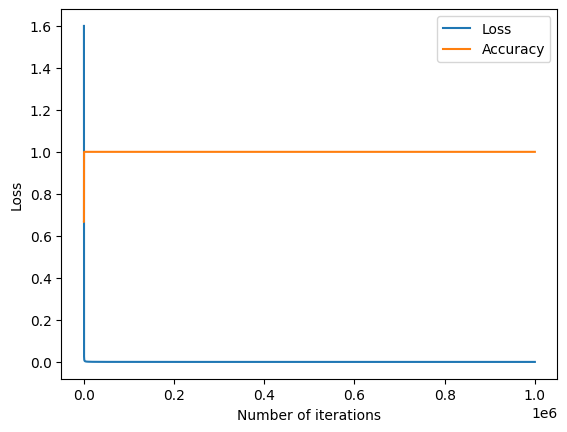

In [39]:
model.plot()

In [40]:
model.eval(X_test, Y_test)

Accuracy: 1.0


In [41]:
Y_pred = model.predict(X_test)

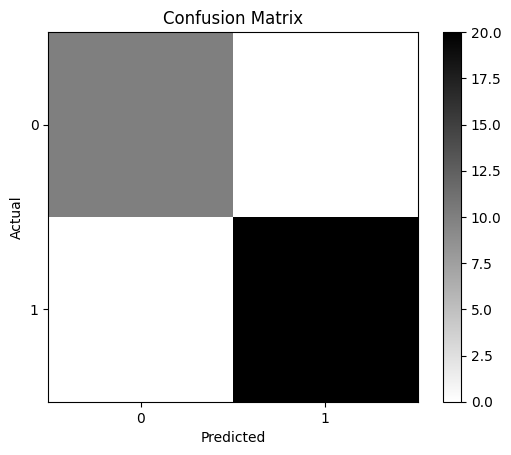

In [42]:
confusion_matrix(Y_test, Y_pred.round())
pyplot.imshow(
    confusion_matrix(Y_test, Y_pred.round()), cmap="binary", interpolation="None"
)
pyplot.title("Confusion Matrix")
pyplot.xlabel("Predicted")
pyplot.ylabel("Actual")
pyplot.xticks([0, 1])
pyplot.yticks([0, 1])
pyplot.colorbar()
pyplot.show()

# Group samples of class 1 and class 3 together to form new class

In [43]:
Y_train = np.where(y == 2, 0, y)

X_train_class1, X_test_class1, Y_train_class1, Y_test_class1 = train_test_split(
    x[Y_train == 0], Y_train[Y_train == 0], test_size=0.2, random_state=42
)
X_train_class2, X_test_class2, Y_train_class2, Y_test_class2 = train_test_split(
    x[Y_train == 1], Y_train[Y_train == 1], test_size=0.2, random_state=42
)

X_train = np.concatenate((X_train_class1, X_train_class2), axis=0)
X_test = np.concatenate((X_test_class1, X_test_class2), axis=0)
Y_train = np.concatenate((Y_train_class1, Y_train_class2), axis=0)
Y_test = np.concatenate((Y_test_class1, Y_test_class2), axis=0)

In [44]:
model = LogisticRegression()

In [45]:
model.fit(X_train, Y_train)


Final Loss: 0.5071257298770863
Final Accuracy: 0.7166666666666667


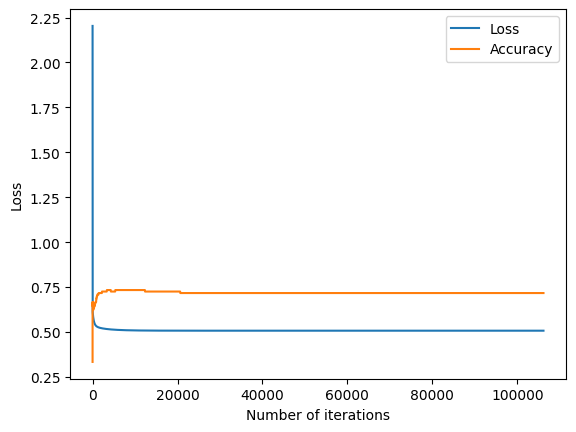

In [46]:
model.plot()

In [47]:
model.eval(X_test, Y_test)

Accuracy: 0.8


In [48]:
Y_pred = model.predict(X_test)

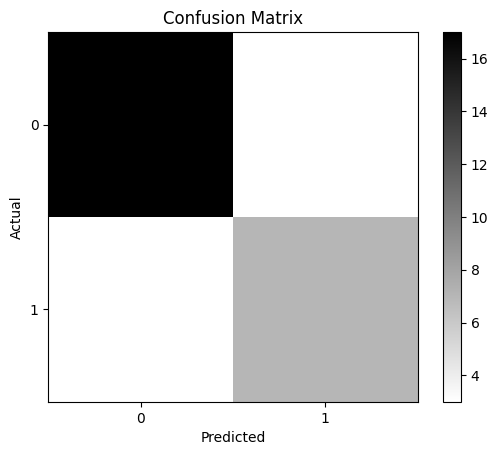

In [49]:
confusion_matrix(Y_test, Y_pred.round())
pyplot.imshow(
    confusion_matrix(Y_test, Y_pred.round()), cmap="binary", interpolation="None"
)
pyplot.title("Confusion Matrix")
pyplot.xlabel("Predicted")
pyplot.ylabel("Actual")
pyplot.xticks([0, 1])
pyplot.yticks([0, 1])
pyplot.colorbar()
pyplot.show()

# Group samples of class 1 and class 2 together to form new class

In [50]:
Y_train = np.where(y == 1, 0, y)
Y_train = np.where(y == 2, 1, Y_train)

X_train_class1, X_test_class1, Y_train_class1, Y_test_class1 = train_test_split(
    x[Y_train == 0], Y_train[Y_train == 0], test_size=0.2, random_state=42
)
X_train_class2, X_test_class2, Y_train_class2, Y_test_class2 = train_test_split(
    x[Y_train == 1], Y_train[Y_train == 1], test_size=0.2, random_state=42
)

X_train = np.concatenate((X_train_class1, X_train_class2), axis=0)
X_test = np.concatenate((X_test_class1, X_test_class2), axis=0)
Y_train = np.concatenate((Y_train_class1, Y_train_class2), axis=0)
Y_test = np.concatenate((Y_test_class1, Y_test_class2), axis=0)

In [51]:
model = LogisticRegression()

In [52]:
model.fit(X_train, Y_train)


Final Loss: 0.00657042776818348
Final Accuracy: 1.0


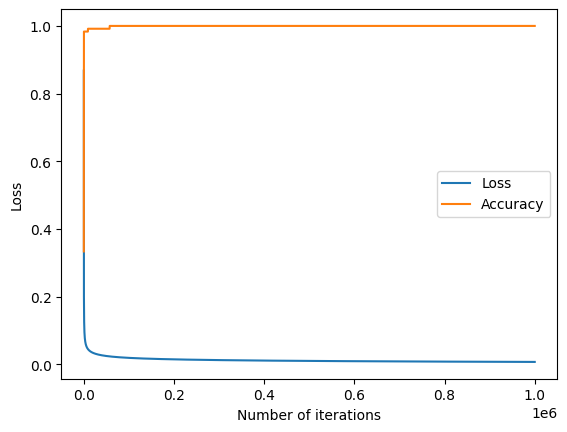

In [53]:
model.plot()

In [54]:
model.eval(X_test, Y_test)

Accuracy: 0.9333333333333333


In [55]:
Y_pred = model.predict(X_test)

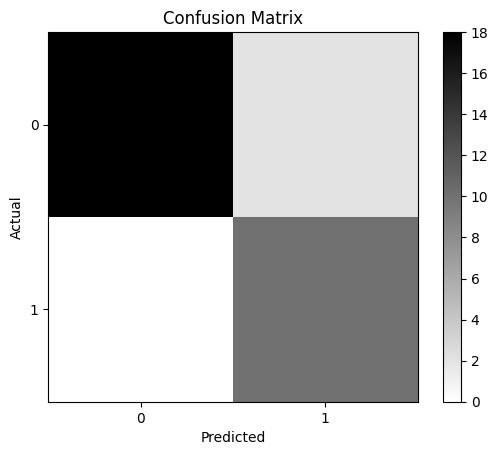

In [56]:
confusion_matrix(Y_test, Y_pred.round())
pyplot.imshow(
    confusion_matrix(Y_test, Y_pred.round()), cmap="binary", interpolation="None"
)
pyplot.title("Confusion Matrix")
pyplot.xlabel("Predicted")
pyplot.ylabel("Actual")
pyplot.xticks([0, 1])
pyplot.yticks([0, 1])
pyplot.colorbar()
pyplot.show()